### Imports

In [28]:
import os
import time
import math
import random
import pickle
import shutil
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from models import *
from autoencoder import *
from utils import *
from data import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

### Configuration Setup

Defines experiment parameters, including latent dimension size, datasets with associated window sizes, embedding usage flags, and distance metrics. The compute device (CPU/GPU) is selected automatically.

In [29]:
# Configuration Parameters
latent_dim = 8

# Dataset configurations: (Name, Class, Sequence Length, Window Size)
ts_configs = [
    ("Temperatures", Temperatures, None, 10),
    ("Saugeen",      Saugeen,      None, 10),
]

# Flags to toggle use of autoencoder embeddings
autoencoder_embedding_flags = [False, True]

# Distance metrics to evaluate
metrics_list = ["euclidean", "manhattan", "cosine"]

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Autoencoder Training and Evaluation

For each dataset, a convolutional autoencoder is trained on windowed time-series data using MSE loss. The model is trained for 30 epochs and saved for later use.

Post-training, reconstruction quality is assessed both qualitatively (via plots) and quantitatively (via MSE) on train, validation, and test splits. These latent representations will be used for model selection in later stages.


Training AE on Temperatures (window_size=10)
  Epoch 1/30 — loss: 0.789285
  Epoch 2/30 — loss: 0.517448
  Epoch 3/30 — loss: 0.422511
  Epoch 4/30 — loss: 0.375775
  Epoch 5/30 — loss: 0.363197
  Epoch 6/30 — loss: 0.346207
  Epoch 7/30 — loss: 0.332563
  Epoch 8/30 — loss: 0.317847
  Epoch 9/30 — loss: 0.313400
  Epoch 10/30 — loss: 0.300462
  Epoch 11/30 — loss: 0.300149
  Epoch 12/30 — loss: 0.290622
  Epoch 13/30 — loss: 0.286895
  Epoch 14/30 — loss: 0.288357
  Epoch 15/30 — loss: 0.278420
  Epoch 16/30 — loss: 0.279365
  Epoch 17/30 — loss: 0.268919
  Epoch 18/30 — loss: 0.263585
  Epoch 19/30 — loss: 0.262296
  Epoch 20/30 — loss: 0.261118
  Epoch 21/30 — loss: 0.267970
  Epoch 22/30 — loss: 0.250749
  Epoch 23/30 — loss: 0.249486
  Epoch 24/30 — loss: 0.257184
  Epoch 25/30 — loss: 0.248313
  Epoch 26/30 — loss: 0.241393
  Epoch 27/30 — loss: 0.244340
  Epoch 28/30 — loss: 0.233146
  Epoch 29/30 — loss: 0.243382
  Epoch 30/30 — loss: 0.239799
Saved AE: autoencoders\ae_Tempera

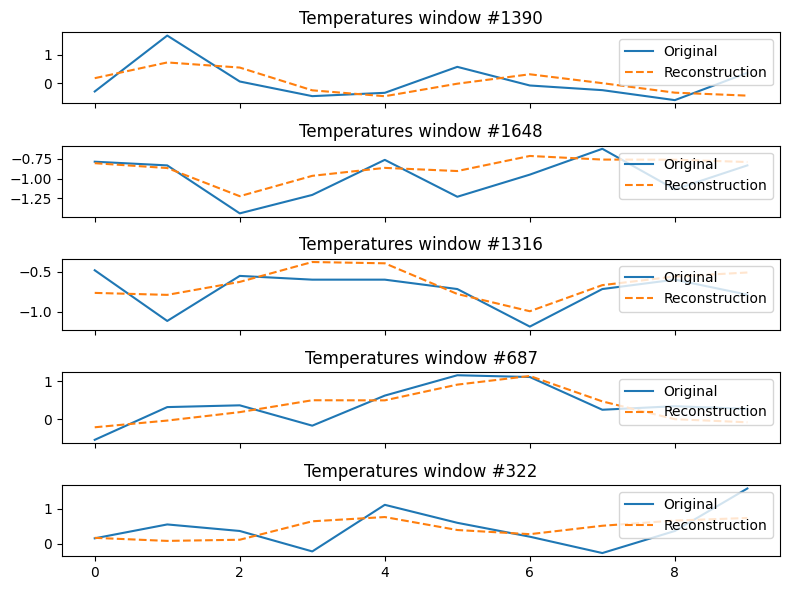


Training AE on Saugeen (window_size=10)
  Epoch 1/30 — loss: 0.550203
  Epoch 2/30 — loss: 0.333448
  Epoch 3/30 — loss: 0.280498
  Epoch 4/30 — loss: 0.231134
  Epoch 5/30 — loss: 0.207398
  Epoch 6/30 — loss: 0.187836
  Epoch 7/30 — loss: 0.171063
  Epoch 8/30 — loss: 0.164703
  Epoch 9/30 — loss: 0.158623
  Epoch 10/30 — loss: 0.146752
  Epoch 11/30 — loss: 0.146411
  Epoch 12/30 — loss: 0.137414
  Epoch 13/30 — loss: 0.131754
  Epoch 14/30 — loss: 0.128852
  Epoch 15/30 — loss: 0.124129
  Epoch 16/30 — loss: 0.120029
  Epoch 17/30 — loss: 0.122064
  Epoch 18/30 — loss: 0.118843
  Epoch 19/30 — loss: 0.115438
  Epoch 20/30 — loss: 0.110683
  Epoch 21/30 — loss: 0.112023
  Epoch 22/30 — loss: 0.108902
  Epoch 23/30 — loss: 0.107039
  Epoch 24/30 — loss: 0.108570
  Epoch 25/30 — loss: 0.098892
  Epoch 26/30 — loss: 0.098845
  Epoch 27/30 — loss: 0.104290
  Epoch 28/30 — loss: 0.101655
  Epoch 29/30 — loss: 0.096790
  Epoch 30/30 — loss: 0.099937
Saved AE: autoencoders\ae_Saugeen.pth


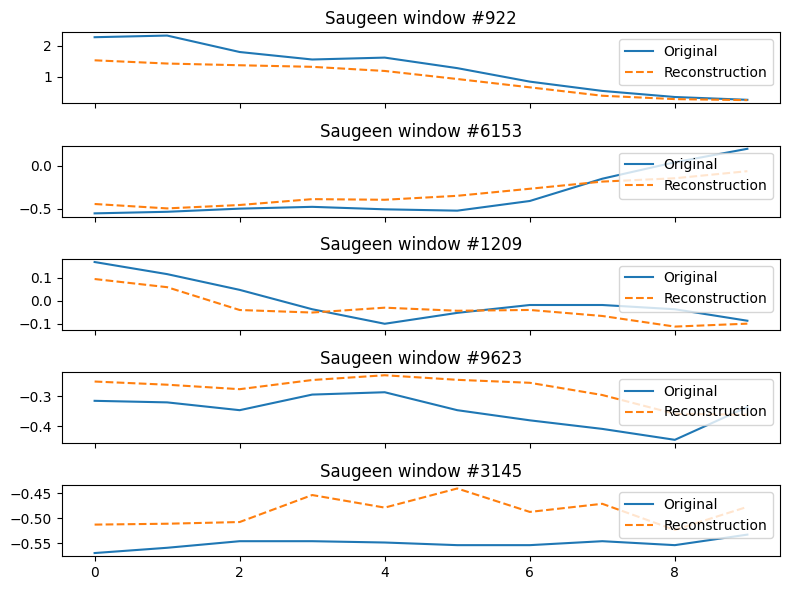

In [30]:
# Autoencoder Training Settings
epochs    = 30
lr        = 1e-3
dropout_p = 0.1

# Ensure a clean autoencoders/ directory
AE_DIR = "autoencoders"
if os.path.exists(AE_DIR):
    shutil.rmtree(AE_DIR)
os.makedirs(AE_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=32, shuffle=True
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join("autoencoders", f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_train)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

### Forecaster Training

For each dataset, a collection of classical and neural network-based forecasters is trained on the training split. Each trained model is saved as a serialized `.pkl` file for future evaluation and selection.

In [31]:
# Ensure a clean models/ directory
MODEL_DIR = "models"
if os.path.exists(MODEL_DIR):
    shutil.rmtree(MODEL_DIR)
os.makedirs(MODEL_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    "DT": DecisionTreeForecaster(),
    "MLP": MLPForecaster(),
    "LSTM": LSTMForecaster(window_size=window_size),
    "BiLSTM": BiLSTMForecaster(window_size=window_size),
    "CNNLSTM": CNNLSTMForecaster(window_size=window_size),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train)

        # save the entire model object as a .pkl
        save_path = os.path.join("models", f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE")


→ Dataset: Temperatures (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP… DONE
    → Training LSTM… 1/30 0.74014 | 15/30 0.34479 | 30/30 0.33779 | DONE
    → Training BiLSTM… 1/30 0.71872 | 15/30 0.34901 | 30/30 0.34393 | DONE
    → Training CNNLSTM… 1/30 0.50990 | 15/30 0.34217 | 30/30 0.32692 | DONE

→ Dataset: Saugeen (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP… DONE
    → Training LSTM… 1/30 0.32878 | 15/30 0.08321 | 30/30 0.08002 | DONE
    → Training BiLSTM… 1/30 0.29361 | 15/30 0.08216 | 30/30 0.07553 | DONE
    → Training CNNLSTM… 1/30 0.15566 | 15/30 0.08403 | 30/3

### Model Loading

Pretrained autoencoders and forecasters are loaded from disk for each dataset. These models are stored in a dictionary for subsequent evaluation and model selection steps.

In [32]:
MODELS_DIR = "models"
AE_DIR = "autoencoders"

os.makedirs(AE_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

loaded = {}
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {AE_DIR}{os.sep}")
    
    # Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP",
        "LSTM",
        "BiLSTM",
        "CNNLSTM",
    ]:
        pkl_path = os.path.join(MODELS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
    print(f"     {name} loaded from {MODELS_DIR}{os.sep}")
    
    # Store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Temperatures (window_size=10)
     AE loaded from autoencoders\
     CNNLSTM loaded from models\

→ Loading models for Saugeen (window_size=10)
     AE loaded from autoencoders\
     CNNLSTM loaded from models\


### Validation Phase: Region of Competence Construction

Each validation window is used to evaluate all forecasters. The model with the lowest prediction error receives the window as part of its Region of Competence (RoC), stored in both raw and latent representations.


In [33]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")


=== Validation RoC for Temperatures (window_size=10) ===
RoC sizes
  ARIMA               109 entries
  ExpSmoothing        170 entries
  LinearRegression     24 entries
  RandomForest         34 entries
  SVR                  51 entries
  GradientBoosting     85 entries
  DT                  157 entries
  MLP                  76 entries
  LSTM                 28 entries
  BiLSTM               50 entries
  CNNLSTM             118 entries

=== Validation RoC for Saugeen (window_size=10) ===
RoC sizes
  ARIMA               505 entries
  ExpSmoothing       1082 entries
  LinearRegression    280 entries
  RandomForest        243 entries
  SVR                 525 entries
  GradientBoosting    273 entries
  DT                  511 entries
  MLP                 527 entries
  LSTM                275 entries
  BiLSTM              741 entries
  CNNLSTM             963 entries


### Latent Space Clustering

K-means clustering is applied to each model’s latent Region of Competence (RoC). The optimal number of clusters is estimated, and cluster centers are decoded for visualization. These centers will be used for Cluster-Based model selection.


=== Compute K-means centers for Temperatures (window_size=10) ===


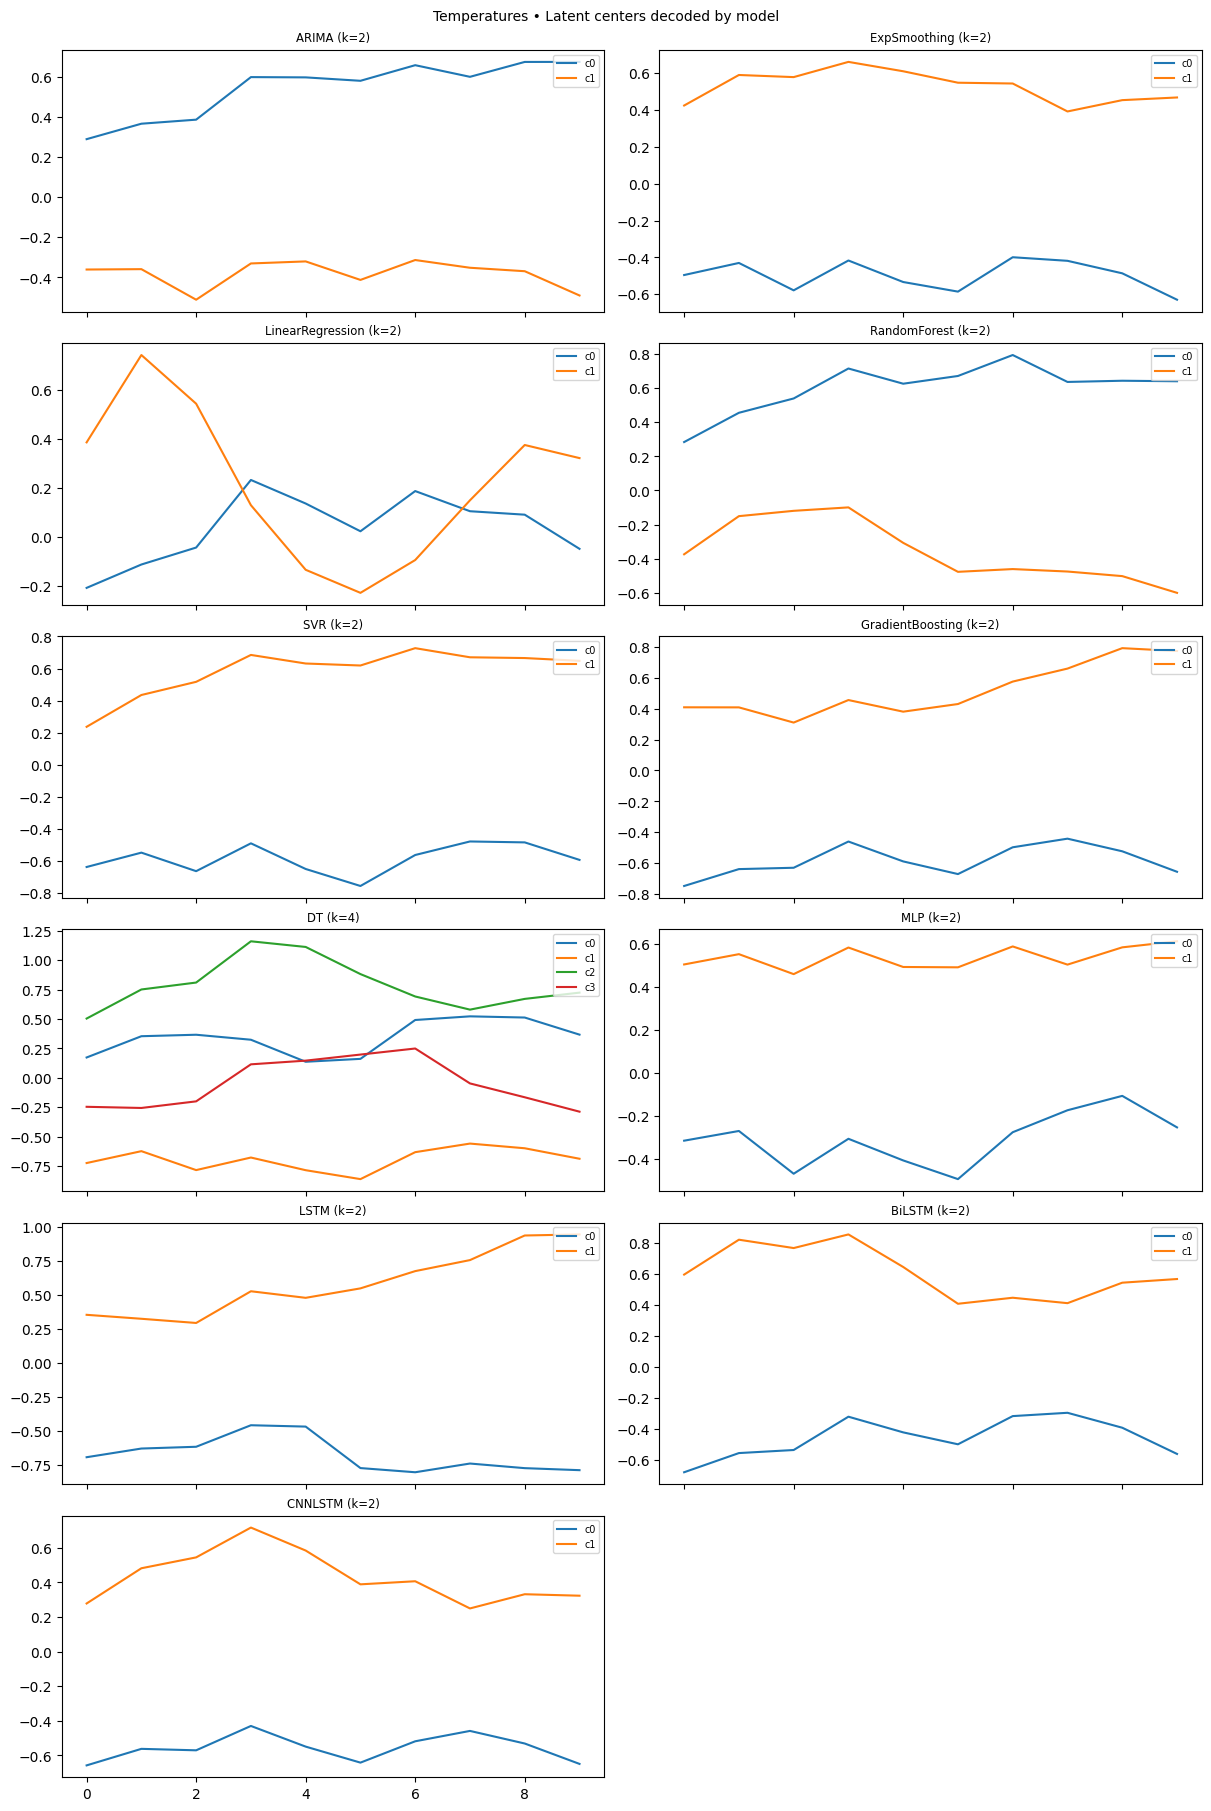


=== Compute K-means centers for Saugeen (window_size=10) ===


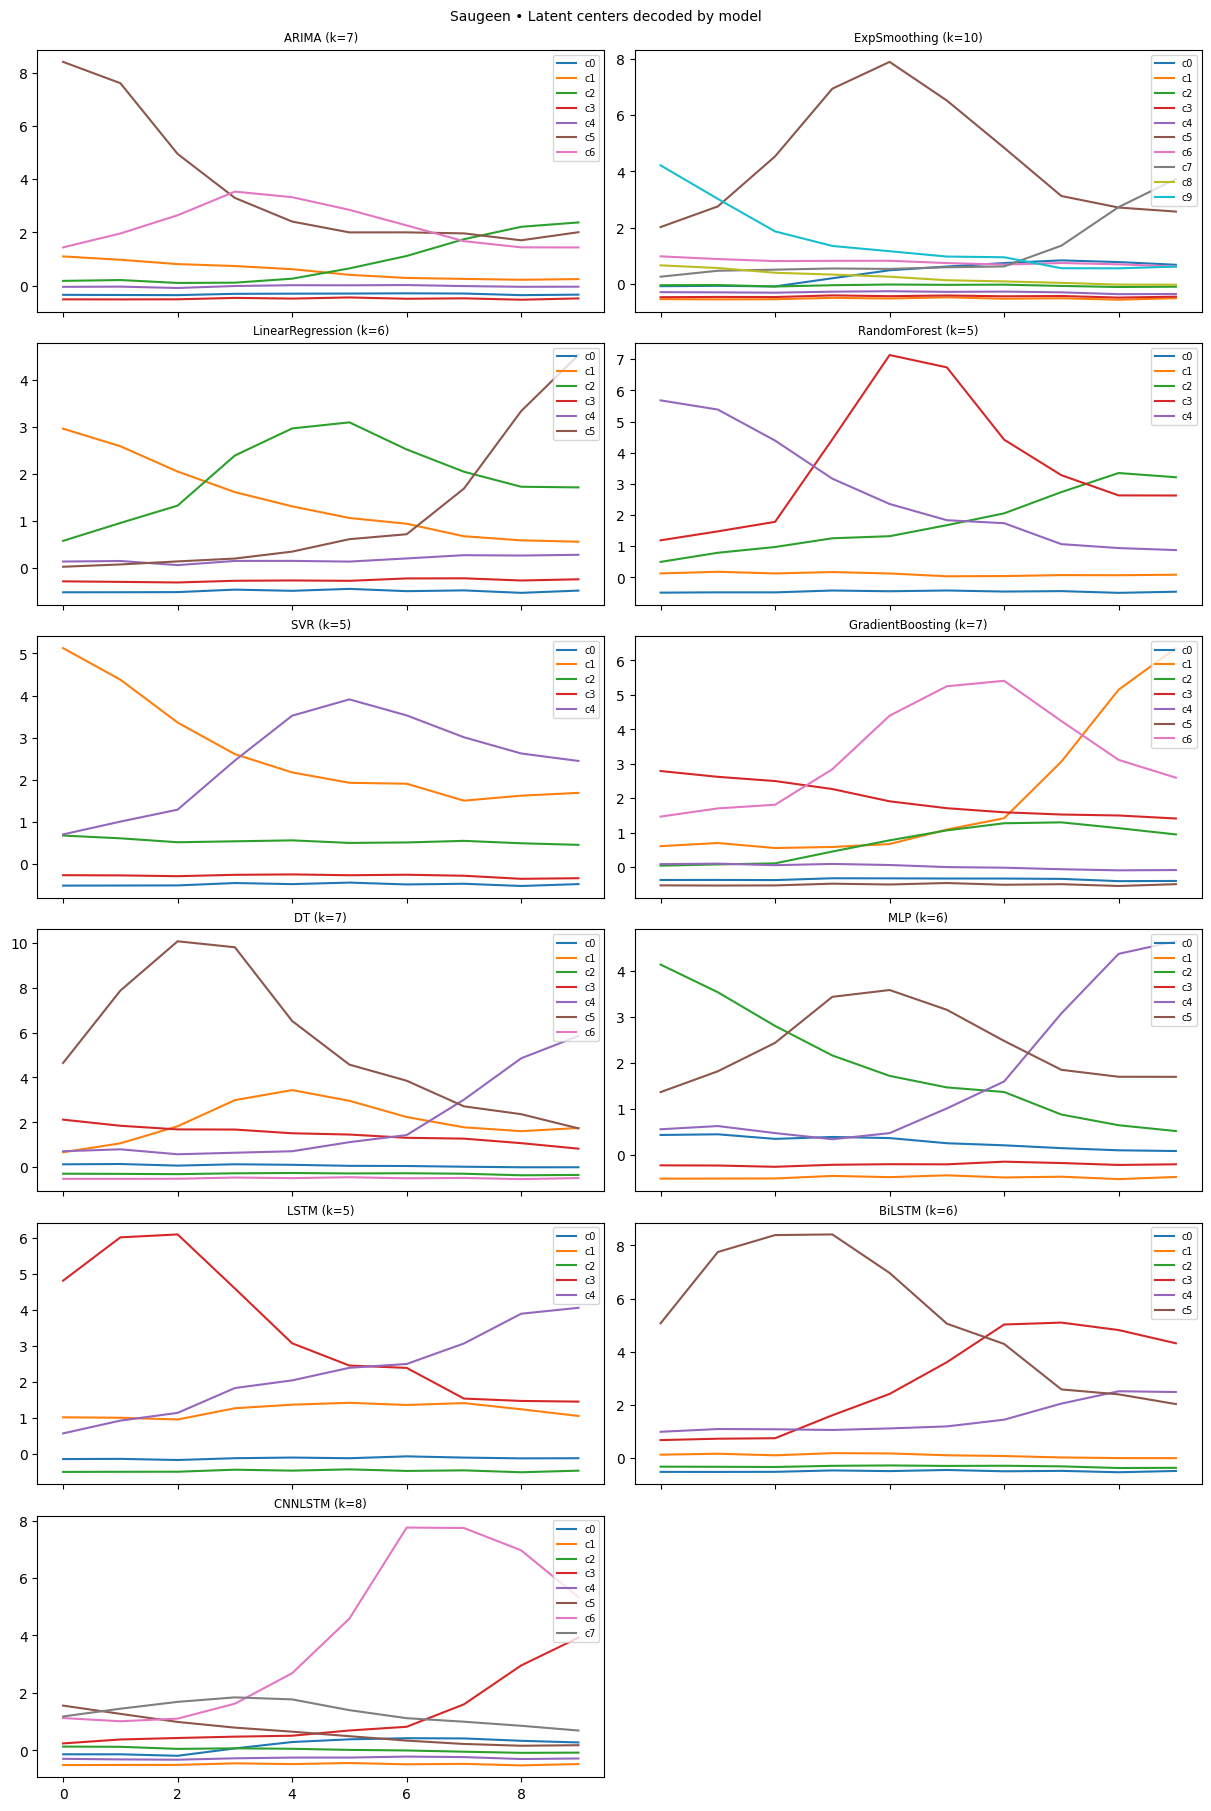

In [ ]:
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Compute K-means centers for {ds_name} (window_size={window_size}) ===")

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear previous latent centers
    for model in forecasters.values():
        model.centers.clear()

    # Determine device for decoding
    decoder_device = next(ae.decoder.parameters()).device

    for name, model in forecasters.items():
        # compute latent-only k-means centers
        N      = len(model.rocs["latent"])
        k_max  = np.sqrt(N/2)
        best_k = model.compute_kmeans_centers(k_max=k_max)

    # Plot
    names = [n for n in forecasters if len(forecasters[n].centers) > 0]
    n_models = len(names)
    if n_models == 0:
        print("  No models have centers to plot.")
        continue

    n_cols = 2
    n_rows = math.ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(12, 3 * n_rows),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, name in zip(axes, names):
        model = forecasters[name]
        for idx, c in enumerate(model.centers):
            # ensure tensor on correct device
            c_tensor = c if isinstance(c, torch.Tensor) else torch.tensor(
                c, dtype=torch.float32
            )
            c_batch = c_tensor.unsqueeze(0).to(decoder_device)  # shape (1, C, L)
            decoded = ae.decoder(c_batch)                       # -> (1, 1, window_size)
            ts_data = decoded.detach().cpu().numpy().flatten()
            ax.plot(ts_data, label=f"c{idx}")
        ax.set_title(f"{name} (k={len(model.centers)})", fontsize="small")
        ax.legend(loc="upper right", fontsize="x-small")

    # turn off any unused subplots
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent centers decoded by model", fontsize="medium")
    plt.show()

### Latent vs. Raw Distance-Based Model Selection

Model selection is performed on the test split using nearest-neighbor lookup in both raw and latent spaces across different distance metrics.


In [35]:
# Lists to collect detailed disagreements and high-level summaries
disagreements = []
summary_list = []

# Ensure a clean results/ directory
RESULTS_DIR = "results"
if os.path.exists(RESULTS_DIR):
    shutil.rmtree(RESULTS_DIR)
os.makedirs("results", exist_ok=True)

print(f"Bottleneck size: {latent_dim}")

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load forecasters
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows = len(X_test)

    for metric in metrics_list:
        # ---- RAW inference ----
        t0 = time.perf_counter()
        raw_preds, raw_models = [], []
        for w in X_test:
            q = w  # raw query
            # nearest‐RoC lookup in raw space
            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for entry in model.rocs["raw"]:
                    d = compute_distance(q, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name
            raw_models.append(best_name)
            raw_preds.append(forecasters[best_name].predict(w))
        time_raw = time.perf_counter() - t0
        mse_raw  = mean_squared_error(y_test, raw_preds)

        # ---- LATENT inference ----
        t1 = time.perf_counter()
        lat_preds, lat_models = [], []
        for w in X_test:
            with torch.no_grad():
                q = ae.encode(w).cpu()  # latent query (torch.Tensor)
            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for entry in model.rocs["latent"]:
                    # entry is already a tensor
                    d = compute_distance(q, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name
            lat_models.append(best_name)
            lat_preds.append(forecasters[best_name].predict(w))
        time_lat = time.perf_counter() - t1
        mse_lat  = mean_squared_error(y_test, lat_preds)

        # ---- Record disagreements ----
        n_dis = 0
        for idx, (rm, lm, yt, pr, pl) in enumerate(zip(raw_models, lat_models, y_test, raw_preds, lat_preds)):
            if rm != lm:
                n_dis += 1
                disagreements.append({
                    "dataset":      ds_name,
                    "metric":       metric,
                    "win_idx":      idx,
                    "raw_model":    rm,
                    "lat_model":    lm,
                    "y_true":       yt,
                    "y_pred_raw":   pr,
                    "y_pred_lat":   pl,
                })
        rate = n_dis / n_windows

        # ---- Append summary ----
        summary_list.append({
            "dataset":          ds_name,
            "metric":           metric,
            "test_mse_raw":     mse_raw,
            "test_mse_lat":     mse_lat,
            "time_raw":         time_raw,
            "time_lat":         time_lat,
            "n_disagreements":  n_dis,
            "disagreement_rate":rate,
        })

        # ---- Print results ----
        print(
            f"[{metric:^9}] "
            f"raw MSE={mse_raw:.4f}@{time_raw:.2f}s | "
            f"lat MSE={mse_lat:.4f}@{time_lat:.2f}s | "
            f"dis={n_dis}/{n_windows} ({rate:.2%})"
        )

df_dis  = pd.DataFrame(disagreements)
df_sum  = pd.DataFrame(summary_list)

# save for later
df_dis.to_csv("results/disagreements.csv", index=False)
df_sum.to_csv("results/validation.csv",     index=False)

Bottleneck size: 8

=== Dataset: Temperatures ===
[euclidean] raw MSE=0.3378@3.21s | lat MSE=0.3412@7.04s | dis=582/903 (64.45%)
[manhattan] raw MSE=0.3414@3.37s | lat MSE=0.3297@6.74s | dis=606/903 (67.11%)
[ cosine  ] raw MSE=0.3376@4.55s | lat MSE=0.3407@14.13s | dis=663/903 (73.42%)

=== Dataset: Saugeen ===
[euclidean] raw MSE=0.1067@76.55s | lat MSE=0.1015@194.15s | dis=3791/5926 (63.97%)
[manhattan] raw MSE=0.1070@95.94s | lat MSE=0.1018@204.16s | dis=3876/5926 (65.41%)
[ cosine  ] raw MSE=0.1187@145.46s | lat MSE=0.1031@495.81s | dis=4805/5926 (81.08%)


### Win Rate Comparison

Among test-time model selection disagreements, we compare the accuracy of raw versus latent space decisions. Win rates are computed per dataset and metric, and merged into the summary table alongside the overall agreement rate.

In [36]:
df_dis['raw_error'] = (df_dis['y_pred_raw'] - df_dis['y_true'])**2
df_dis['lat_error'] = (df_dis['y_pred_lat'] - df_dis['y_true'])**2
df_dis['winner'] = np.where(df_dis['lat_error'] < df_dis['raw_error'],
                            'latent', 'raw')

# Count wins among disagreements
win_counts = (
    df_dis
    .groupby(['dataset','metric','winner'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_wins','latent':'latent_wins'})
)

# Compute win‐rates (conditional on disagreement)
win_rates = win_counts.div(win_counts.sum(axis=1), axis=0) \
                      .rename(columns={'raw_wins':'raw_win_rate',
                                       'latent_wins':'latent_win_rate'})

# Merge rates into the summary table
df_full = (
    df_sum
    .merge(win_rates.reset_index(), on=['dataset','metric'], how='left')
    .fillna(0)
    .assign(
        same_decision_rate = 1 - df_sum['disagreement_rate']
    )
)

# Display results
display(
    df_full[[
        'dataset','metric',
        'raw_win_rate','latent_win_rate','same_decision_rate'
    ]]
)

# Save for later
win_rates.to_csv("results/win_rates.csv", index=False)

,dataset,metric,raw_win_rate,latent_win_rate,same_decision_rate
0,Temperatures,euclidean,0.500000,0.500000,0.355482
1,Temperatures,manhattan,0.490099,0.509901,0.328904
2,Temperatures,cosine,0.478130,0.521870,0.265781
3,Saugeen,euclidean,0.508573,0.491427,0.360277
4,Saugeen,manhattan,0.514190,0.485810,0.345933
5,Saugeen,cosine,0.532362,0.467638,0.189166


### Weighted Win-Rate and SSE Reduction

We compute per-window MSE differences to evaluate whether raw or latent selection yields lower errors. Win rates are weighted by the maximum error per window. Additionally, we report the percentage reduction in total sum of squared errors (SSE) when using latent over raw selection.

In [37]:
print(f"Bottleneck size: {latent_dim}")
# --- compute per-window MSEs and delta using actual column names ---
df_dis['mse_raw']    = (df_dis['y_pred_raw'] - df_dis['y_true'])**2
df_dis['mse_latent'] = (df_dis['y_pred_lat'] - df_dis['y_true'])**2
df_dis['delta_mse']  = df_dis['mse_raw'] - df_dis['mse_latent']


# --- weighted win-rate (weight = max error per window) ---
df_dis['weight'] = df_dis[['mse_raw', 'mse_latent']].max(axis=1)
w_raw    = df_dis.loc[df_dis['delta_mse'] < 0, 'weight'].sum()
w_latent = df_dis.loc[df_dis['delta_mse'] > 0, 'weight'].sum()
wr_raw   = w_raw    / (w_raw + w_latent)
wr_latent= w_latent / (w_raw + w_latent)
print(f"    Weighted raw win-rate:    {wr_raw:.3f}")
print(f"    Weighted latent win-rate: {wr_latent:.3f}")

# --- percent reduction in total SSE ---
sse_raw    = df_dis['mse_raw'].sum()
sse_latent = df_dis['mse_latent'].sum()
pct_reduction = (sse_raw - sse_latent) / sse_raw * 100
print(f"    Latent vs. raw SSE reduction: {pct_reduction:.2f}%")

Bottleneck size: 8
    Weighted raw win-rate:    0.464
    Weighted latent win-rate: 0.536
    Latent vs. raw SSE reduction: 8.27%


### Cluster-Based Latent Selection

Model selection is performed using nearest latent cluster centers instead of full RoCs. For each test window, the closest cluster center (per metric) is used to select the forecasting model. Inference time and test MSE are recorded.


In [38]:
# Load previously computed summary for raw vs. latent
df_prev = pd.read_csv("results/validation.csv")

summary_list = []

print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # rebuild splits
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load forecasters and AE
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows   = len(X_test)

    for metric in metrics_list:
        # ---- LATENT inference (cluster-center lookup) ----
        t0 = time.perf_counter()
        lat_preds = []
        for w in X_test:
            # encode window
            with torch.no_grad():
                q = ae.encode(w).cpu()

            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for center in model.centers:
                    d = compute_distance(q, center, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name

            lat_preds.append(forecasters[best_name].predict(w))

        time_cluster = time.perf_counter() - t0
        mse_cluster  = mean_squared_error(y_test, lat_preds)

         # fetch standard latent‐based results
        prev_row      = df_prev[(df_prev['dataset']==ds_name)&(df_prev['metric']==metric)].iloc[0]
        mse_standard  = prev_row['test_mse_lat']
        time_standard = prev_row['time_lat']

        # compute delta and print with arrow‐style indicator
        delta = mse_cluster - mse_standard
        sign  = "+" if delta > 0 else "–"
        print(
            f"[{metric:^9}] "
            f"cluster MSE={mse_cluster:.4f}@{time_cluster:.2f}s "
            f"{sign}{abs(delta):.4f} vs. std ({mse_standard:.4f}@{time_standard:.2f}s)"
        )

        summary_list.append({
            "dataset":       ds_name,
            "metric":        metric,
            "cluster_mse":   mse_cluster,
            "time_cluster":  time_cluster,
        })

# tabulate and save
df_sum = pd.DataFrame(summary_list)
df_sum.to_csv("results/cluster.csv", index=False)

Bottleneck size: 8

=== Dataset: Temperatures ===
[euclidean] cluster MSE=0.3102@1.51s –0.0309 vs. std (0.3412@7.04s)
[manhattan] cluster MSE=0.3216@1.38s –0.0081 vs. std (0.3297@6.74s)
[ cosine  ] cluster MSE=0.3113@1.71s –0.0295 vs. std (0.3407@14.13s)

=== Dataset: Saugeen ===
[euclidean] cluster MSE=0.1046@16.31s +0.0031 vs. std (0.1015@194.15s)
[manhattan] cluster MSE=0.1023@16.89s +0.0004 vs. std (0.1018@204.16s)
[ cosine  ] cluster MSE=0.1022@21.21s –0.0010 vs. std (0.1031@495.81s)
